# Spectral Clustering

## 1. Explanation of the algorithm

As the other unsupervised algorithm, spectral clustering goal is to assign label to unlabelled datas. It's a good algorithm to find clusters when the datas don't match with the common algorithms : for example it can handle intertwined spirals or circle datasets where basics unsupervised algorithm cannot. The algorithm takes its origin in the graph theory where the approach is to identify the groups of datas which are linked. But the algorithm can work with non-graph data like the one we usually have.

The process to do a spectral clustering is is four steps : building a similarity graph with the datas, Determine the Adjacency matrix W, Degree matrix D and the Laplacian matrix L, Compute the eigenvectors of the matrix L and finally take the second smallest eigenvector as input, train a k-means model on it and use it to classify the data

### 1.1. Building a similarity graph with the datas

The first step consist in construct a similarity graph with the datas : we transform our data from matrix to graph. We use the k_neihbor algorithm to do so : the algorithm will treat every data as a node and will construct a graph with an edge between the k neighbor of each point of data. We will see in practice that the algorithm can use other algorithm to do the transformation.

### 1.2. Determine the Adjacency matrix W, Degree matrix D and the Laplacian matrix L

We can represent a graph as an adjency matrix where for every node in our graph, we put a one if there is a link with an other node and a zero if there is no link.

Then we build the Degree matrix, the degree is the number of nodes connected to a node. So it's a diagonal matrix with the number of connexion we the node at the (n,n) position.

Now we calculate the graph Laplacian : to do so we subtract the adjacency matrix from the degree matrix.
The graph laplacian has good properties which are useful to the algorithm.

### 1.3. Compute the eigenvectors of the matrix L

The concept of eigen values is used is this algorithm. For a A matrix if it exists an x vector which is not only 0 and a scalar λ such as Ax = λx so x is a eigen vector of A with the eigen value λ. If A is applyed to the matrix most of the vectors will be in a complete different position but not the eigen vectors. These eigen vectors are needed to do the spectral clustering. we can calculate them with the linalg.eig function of numpy.

### 1.4. Take the second smallest eigenvector as input, train a k-means model on it and use it to classify the data

The next step is to sort the eigen values. The value of the eigen vector and specially the difference between them tell us the number of clusters. The second eigen value is called the fiedler value, and its corresponding vector is called the fiedler vector. Le fidler value approximates the minimum graph cut needed to separate the graph into two connected components.
If the number of clusters is bigger than 2 we apply a kmean algorithm on the firsts eigen vectors (before the gap between the eigen values)and in this way we have the result of the algorithm : every node is affected to a category.

## 2. Testing the algorithm

As I explain in the introduction, the spectral clustering is very useful for special datasets, where other unsupervised algorithm would not work. A good example is the circle datasets.
If we apply a basic kmeans algorithm on this dataset, we will find a very bad result :

### 2.1. Testing the kmean algorithm on a specific dataset

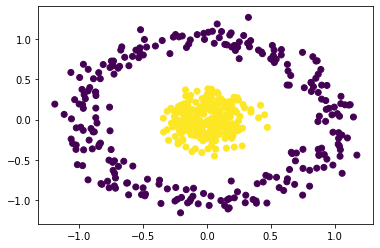

In [32]:
from sklearn.datasets import make_circles
from sklearn.neighbors import kneighbors_graph
import numpy as np
import matplotlib.pyplot as plt
# simulating circle dataset
X, labels = make_circles(n_samples=500, noise=.1, factor=.2)
plt.scatter(X[:,0],X[:,1],c=labels)

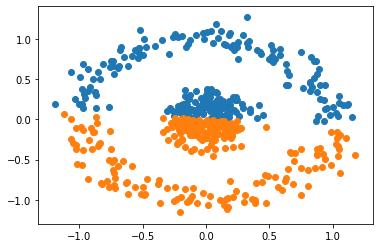

In [33]:
#Applying a kmean algorithm on it
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2,random_state=0)
y_pred = km.fit_predict(X)
plt.scatter(X[y_pred==0, 0], X[y_pred==0, 1])
plt.scatter(X[y_pred==1, 0], X[y_pred==1, 1])

In [34]:
from sklearn import metrics
print(metrics.accuracy_score(labels, y_pred))

0.522


As forseen the kmean algorithm cut the two circle in clusters which are not at all the two original clusters

This is why here we must use the spectral clustering.

### 2.2. Applying the spectral clustering

#### 2.2.1. Building a similarity graph with the datas

To build the similarity graph we are going to construct a k-nearest neighbors graph.

In [35]:
from sklearn.neighbors import kneighbors_graph
A = kneighbors_graph(X, n_neighbors=5).toarray()
print(A)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### 2.2.2. Determine the Adjacency matrix W, Degree matrix D and the Laplacian matrix L

To do so we use the eigenvectors of the Graph Laplacian  and we find the eigenvalues 

In [36]:
D = np.diag(A.sum(axis=1))
L = D-A

In [37]:
# find the eigenvalues and eigenvectors
vals, vecs = np.linalg.eig(L)

# sort the eigen values
vecs = vecs[:,np.argsort(vals)]
vals = vals[np.argsort(vals)]

# He we use the  Fiedler value to find best cut to separate data. We don't need kmean because we only have two clusters
clusters = vecs[:,1] > 0

Finally we obtain these results

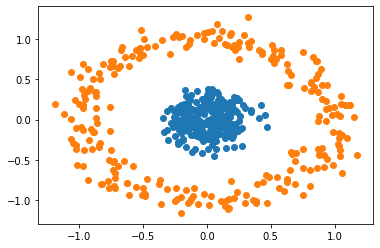

In [38]:
plt.scatter(X[clusters==True, 0], X[clusters==True, 1])
plt.scatter(X[clusters==False, 0], X[clusters==False, 1])

Here we have decomposed the spectral clustering into the the different steps we explained in the introduction.
But we sklearn we can use in a simpler way the algorithm

C:\Users\Florian\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


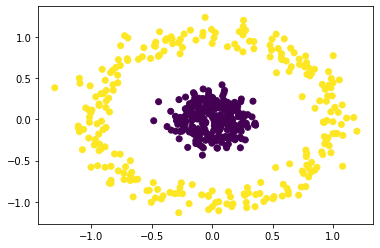

In [23]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=0)
sc_clusters = sc.fit(X)
plt.scatter(X[:,0], X[:,1], c=sc_clusters.labels_)

And we can see that we obtain the same results

In [24]:
print(metrics.accuracy_score(labels, sc_clusters.labels_))

0.0


We can verify with the metrics that spectral clustering is working perfectly in this case

## 3. Influence of parameters and hyperparameters

### 3.1. Test of parameters

In the first part we saw that the algorithm is working good with circle, let's try with other kind of shape

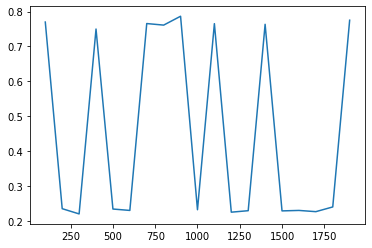

In [25]:
#Moons
from sklearn.datasets import make_moons
#test on the size of the dataset
accuracy = list()
sample_range = range(100,2000,100)
for n in sample_range:
    X, y = make_moons(n_samples=n, noise=.1)
    sc = SpectralClustering(n_clusters=2, random_state=0)
    sc_clusters = sc.fit(X)
    accuracy.append(metrics.accuracy_score(y, sc_clusters.labels_))
plt.plot(sample_range,accuracy)

We can see that the algorithm can have very good result, but it's pretty random with the number of samples in the dataset

In the precedent example we saw the efficiency of the algorithm on original shape datasets, let's watch here the results with a basic dataset made with makeblobs.

In [26]:
#size of the dataset
accuracy = list()
size_range = range(500,1200,20)
for n in size_range:
    X, y = make_blobs(n_samples=n, centers=3, n_features=2, random_state=0)
    sc = SpectralClustering(n_clusters=3, random_state=0)
    sc_clusters = sc.fit(X)
    accuracy.append(metrics.accuracy_score(y, sc_clusters.labels_))
plt.plot(size_range,accuracy)

NameError: name 'make_blobs' is not defined

Again the size of the dataset make very random results on the accuracy

In [ ]:
#numbers of centers : since we saw that there are good results with a n_sample of 1000, it's the parameter we take
accuracy = list()
center_range = range(1,10)
for n in center_range:
    X, y = make_blobs(n_samples=1000, centers=n, n_features=2, random_state=0)
    sc = SpectralClustering(n_clusters=n,random_state=0)
    sc_clusters = sc.fit(X)
    accuracy.append(metrics.accuracy_score(y, sc_clusters.labels_))
plt.plot(center_range,accuracy)

As expected, the results are declining with the increasing number of centers.

CONCLUSION ON TEST OF PARAMETERS : Compared to what I saw last week with the random forest, the efficiency of the algorithm has very good but also very random results depending on the paramters of the dataset, it's very strange and it doesn't make the algorithm very trusful.

### 3.2. Test of hyperparameters

Now let's test the hyperparameters of the algorithm

In [ ]:
#affinity parameter
X, y = make_circles(n_samples=1000, noise=0.1, factor=0.2,random_state=0)
accuracy = list()
affinity = ['nearest_neighbors', 'rbf']
for n in affinity:
    sc = SpectralClustering(n_clusters=2,affinity=n,random_state=0)
    sc_clusters = sc.fit(X)
    accuracy.append(metrics.accuracy_score(y, sc_clusters.labels_))
plt.scatter(affinity,accuracy)

Here I tried two different algorithm to construct the affinity matrix (first part of the algorithm process as explained in the introduction). Nearest_neighbors mean that the spectral clustering algorithm use a graph of nearest neighbors to build the affinity matrix and RBF mean that the radial basis function was used to build it. We can see a big difference between the two methods. Backstage I try to move n_sample of the make_circle function and as we can see in the precedent tests, the results vary a lot : sometimes nearest_neighbors is better, sometimes not.

In [ ]:
#n_init parameter
X, y = make_circles(n_samples=1200, noise=0.1, factor=0.2,random_state=0)
accuracy = list()
n_init = range(1,20)
for n in n_init:
    sc = SpectralClustering(n_clusters=2,n_init=n,random_state=0)
    sc_clusters = sc.fit(X)
    accuracy.append(metrics.accuracy_score(y, sc_clusters.labels_))
plt.scatter(n_init,accuracy)

We can see a big difference between the results which are not very good. But if we put affinity ='nearest_neighbors' we obtain a 100% result. 

CONCLUSION ABOUT HYPERPARAMETERS : we can see that the hyperparameters are very dependant each others. Again it's very complicated to find the good balance between all the parameters and hypermparamters especially within this algorithm which seem to have a very random behavior. The best solution would be to do a lot of test or to use a Grid search, a random search or the hyperoptimizer.

## 4. Spectral Cluestering on Pyrat Datas

### 4.1. Predicting winner

The dataset is made with mazes of mazeHeight = 8, mazeWidth = 10 and number_of_cheeses = 10 using the script available in the last TP

In [ ]:
# Loading the datas
filename = "dataX.npz"
loaded_npz = np.load(filename)
x = loaded_npz['data']
filename = "dataY.npz"
loaded_npz = np.load(filename)
y = loaded_npz['data']

In [ ]:
#Trying to predict who has won with spectral clustering based on a maze dataset
sc = SpectralClustering(n_clusters=3,random_state=0)
sc_clusters = sc.fit(x)
print(metrics.accuracy_score(y, sc_clusters.labels_))

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
report = classification_report(y_true=y,y_pred=sc_clusters.labels_)
matrix = confusion_matrix(y_true=y,y_pred=sc_clusters.labels_)
print("Testing Set:")
print(report)
print(matrix)
plt.matshow(matrix)
plt.colorbar()
plt.xlabel("Real class")
plt.ylabel("Predicted class")

We can see that the results are very bad : less than a picking by chance. This method must nod be adapted to this kind of problem.

### 4.2. Predicting the player moves

Je n'ai pas réussi à générer un dataset de player move utilisable par l'algorithme. Si c'est possible, je reviendrai vers vous pendant la prochaine sécance pour que vous m'indiquez comment faire. Mieux vaut tard que jamais ! Merci par avance.

# Sources

https://www.cs.cmu.edu/~aarti/Class/10701/readings/Luxburg06_TR.pdf

https://towardsdatascience.com/spectral-clustering-aba2640c0d5b

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

https://fr.wikipedia.org/wiki/Partitionnement_spectral

https://fr.wikipedia.org/wiki/Valeur_propre,_vecteur_propre_et_espace_propre

https://fr.wikipedia.org/wiki/Matrice_laplacienne

https://towardsdatascience.com/unsupervised-machine-learning-spectral-clustering-algorithm-implemented-from-scratch-in-python-205c87271045